## Time Series Forecasting Multivariato con Bike Sharing Demand

**_Scopo dell’analisi:_**  
Predire la domanda futura di biciclette (prossima ora), usando una finestra temporale passata (ultime 24 ore) e le caratteristiche meteo e temporali.  

**_Modelli utilizzati:_**  
CNN 1D, LSTM, GRU.  

**_Obiettivi finali:_**  
Confronto tra modelli e scelta del migliore.  

Fonte: [kaggle.com](https://www.kaggle.com/competitions/bike-sharing-demand/data)

## Import delle librerie necessarie

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Import dataset

**Datetime** - hourly date + timestamp   
**Season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**Holiday** - whether the day is considered a holiday  
**Workingday** - whether the day is neither a weekend nor holiday   
**Weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy;
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist;
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds;
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**Temp** - temperature in Celsius   
**Atemp** - "feels like" temperature in Celsius   
**Humidity** - relative humidity   
**Windspeed** - wind speed   
**Casual** - number of non-registered user rentals initiated   
**Registered** - number of registered user rentals initiated   
**Count** - number of total rentals   

In [2]:
df = pd.read_csv("./data/raw/data.csv")

## Analisi dataset

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


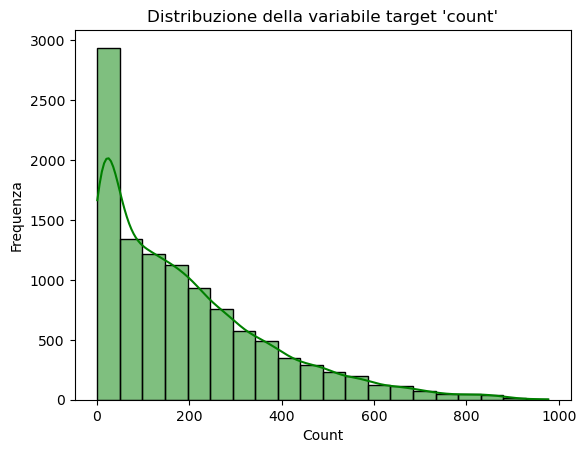

In [15]:
sns.histplot(data=df, x='count', kde=True, bins=20, color="green")
plt.title("Distribuzione della variabile target 'count'")
plt.xlabel("Count")
plt.ylabel("Frequenza")
plt.show()

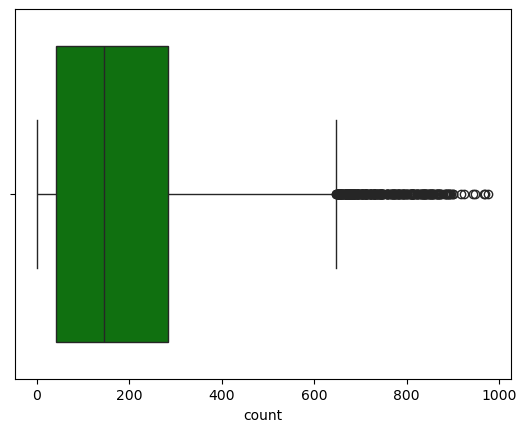

In [25]:
sns.boxplot(data=df, x='count', color='green')
plt.show()

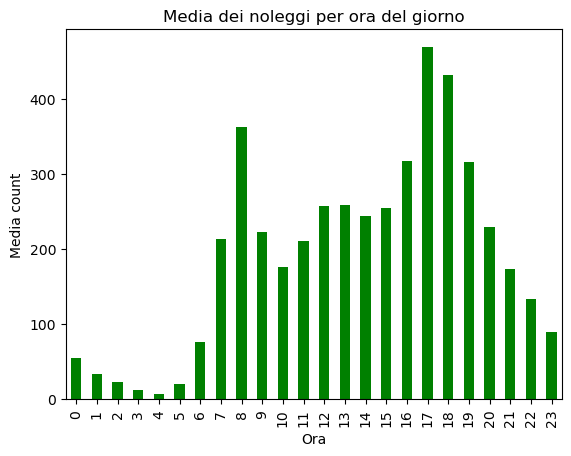

In [16]:
df.groupby("hour")["count"].mean().plot(kind='bar', color='green')
plt.title("Media dei noleggi per ora del giorno")
plt.xlabel("Ora")
plt.ylabel("Media count")
plt.show()

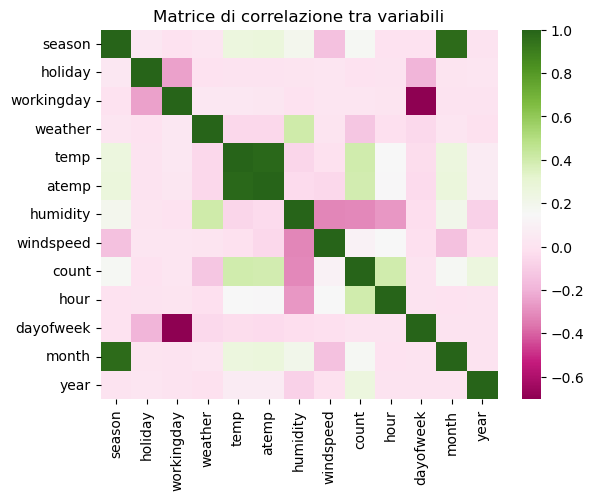

In [14]:
sns.heatmap(df.corr(), cmap='PiYG')
plt.title("Matrice di correlazione tra variabili")
plt.show()

## Preprocessing

In [7]:
# parsing datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df = df.drop(columns=["datetime"])

In [8]:
# rimozione colonne ridondanti
df = df.drop(columns=["casual", "registered"])

In [9]:
# suddivisione temporale train/val/test (70% - 15% - 15%)
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

In [10]:
# normalizzazione
from sklearn.preprocessing import StandardScaler

# Feature
features = ["temp", "atemp", "humidity", "windspeed"]
scaler_features = StandardScaler()
scaler_features.fit(train_df[features])

train_df[features] = scaler_features.transform(train_df[features])
val_df[features] = scaler_features.transform(val_df[features])
test_df[features] = scaler_features.transform(test_df[features])

# Target
scaler_target = StandardScaler()
scaler_target.fit(train_df[['count']])

train_df['count'] = scaler_target.transform(train_df[['count']])
val_df['count'] = scaler_target.transform(val_df[['count']])
test_df['count'] = scaler_target.transform(test_df[['count']])

In [11]:
# salvataggio dataset processati
train_df.to_csv("data/processed/train.csv", index=False)
test_df.to_csv("data/processed/test.csv", index=False)
val_df.to_csv("data/processed/val.csv", index=False)

## Modellazione

### Scelta dei Modelli
Per affrontare il problema sono stati implementati e confrontati 3 modelli di rete neurale:

_CNN1D:_ adatta a catturare pattern locali nei dati temporali.

_LSTM:_ efficace per sequenze con dipendenze a lungo termine.

_GRU:_ variante semplificata delle LSTM, con prestazioni comparabili ma maggiore efficienza.

Queste reti sono implementate come moduli PyTorch nei file: models/cnn1d_model.py, models/lstm_model.py, models/gru_model.py.

La scelta è ricaduta su questi modelli per la loro efficacia nel modellare dati sequenziali e per permettere un confronto tra architetture convoluzionali e ricorrenti.

### Configurazione dell’Addestramento
L’addestramento dei modelli è gestito da una classe `Trainer`, contenuta nel file _trainer.py_. I parametri di configurazione sono caricati dinamicamente da un file Json (_config.json_), che permette di cambiare facilmente rete e iperparametri senza modificare il codice sorgente.

I principali iperparametri utilizzati sono:

- batch_size = 32
- window_size = 24
- learning_rate = 0.01
- momentum	= 0.9
- epochs = 100
- loss_target = 0.01
- optimizer	= SGD
- loss_function	= MSELoss
- early_stop_patience = 10

### Strategia di Addestramento
L'addestramento segue questi passaggi:

1. **Costruzione del modello** secondo il tipo specificato.

2. **Inizializzazione** di ottimizzatore e funzione di loss.

3. **Addestramento su epoche multiple** con monitoraggio della loss sul set di validazione.

4. **Early stopping** se la validation loss non migliora oltre un certo margine per un numero di epoche consecutive, l’addestramento viene interrotto.

5. **Salvataggio dei modelli:**

    - best_model.pth: il migliore raggiunto in validazione.

    - last_model.pth: quello dell’ultima epoca completata.


Durante il training, è possibile **caricare l’ultimo modello** salvato (_reload_last_model: True_) per riprendere da dove si era interrotto.

## Addestramento e Valutazione

## Conclusioni